# Tutorial for irt_parameter_estimation

Here, we show a quick sample usage of the MLE routines in irt_parameter_estimation.

First of all, here is a sample item characteristic curve (ICC), a logistic function given item paramters:
 * a=10 (discimination)
 * b=0.6 (difficulty)
 * c=0.25 (guessing parameter)

This could be a multiple choice question that:
 * has four equally interesting choices
 * is slightly harder than average
 * discriminates between novices and experts very well

This explains the likelihood that a user at any given ability level (x axis) will answer the question correctly.

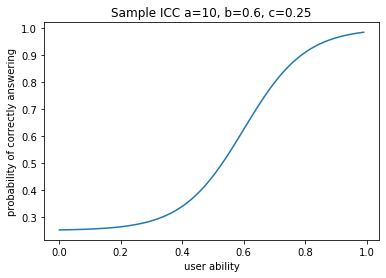

In [1]:
import numpy as np
import irt_parameter_estimation
import matplotlib.pyplot as plt

np.random.seed(2)  # Chosen so 3PL will converge below

# Sample question score curve
a = 10
b = 0.6
c = 0.25

theta = np.arange(0, 1, 0.01)
prob_correct = irt_parameter_estimation.logistic3PLabc(a, b, c, theta)
plt.plot(theta, prob_correct)
plt.xlabel("user ability")
plt.ylabel("probability of correctly answering")
_ = plt.title(f"Sample ICC a={a}, b={b}, c={c}")

Next, we create some sample user abilities with np.random.normal.

These users have mean ability of 0.5 with std 0.2.

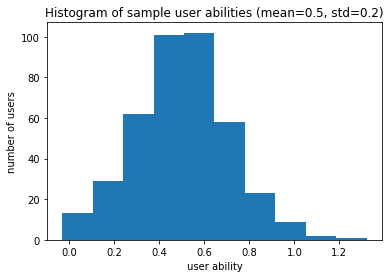

In [2]:
mean_user_ability = 0.5
std_user_ability = 0.2
n_users = 400
user_abilities = np.random.normal(mean_user_ability, std_user_ability, n_users)
plt.hist(user_abilities)
plt.xlabel("user ability")
plt.ylabel("number of users")
_ = plt.title(f"Histogram of sample user abilities (mean=0.5, std=0.2)")

Next, we sample the ICC to generate the probability each user will answer the question correctly and draw a random variable to decide whether each user gets the question right.

We define bins of size 0.1 and will use them below as well.

The plot shows the correct and incorrect responses binned by user ability level in green and red respectively.

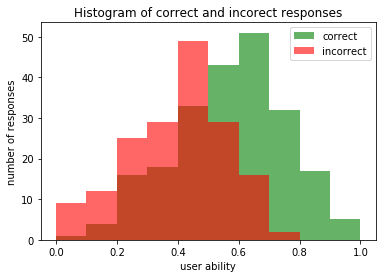

In [3]:
user_probability_correct = irt_parameter_estimation.logistic3PLabc(
    a,
    b,
    c,
    user_abilities,
)
user_results = np.random.rand(n_users) < user_probability_correct
bins = np.arange(0, 1.1, 0.1)
correct_users = user_abilities[user_results]
incorrect_users = user_abilities[np.logical_not(user_results)]
plt.hist(correct_users, bins=bins, alpha=0.6, color="green", label="correct")
plt.hist(incorrect_users, bins=bins, alpha=0.6, color="red", label="incorrect")
plt.legend()
plt.xlabel("user ability")
plt.ylabel("number of responses")
_ = plt.title("Histogram of correct and incorect responses")

Next, we create the binned data more efficiently using numpy.

The MLE routines need the correct responses and total responses binned by ability (*r* and *f* in Baker's terminology).

There are fewer total responses (f) on the extreme ends because there are fewer total users at those levels of ability

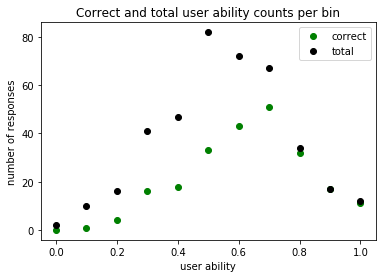

In [4]:
correct_binned = np.bincount(np.digitize(correct_users, bins[:-1]), minlength=11)
total_binned = np.bincount(np.digitize(user_abilities, bins[:-1]), minlength=11)
plt.plot(bins, correct_binned, 'go', label='correct')
plt.plot(bins, total_binned, 'ko', label='total')
plt.legend()
plt.xlabel("user ability")
plt.ylabel("number of responses")
_ = plt.title("Correct and total user ability counts per bin")

We can visualize the reconstructed ICC by plotting the correct reponses divided by the total responses (r / f).

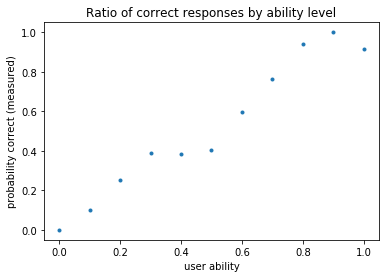

In [5]:
measured_prob_correct = correct_binned / total_binned
plt.plot(bins, measured_prob_correct, '.')
plt.xlabel("user ability")
plt.ylabel("probability correct (measured)")
_ = plt.title("Ratio of correct responses by ability level")

Now we are ready to do the maximum likelihood estimation (MLE) to reconstruct the item parameters (in this case a, b, and c).

First, we do the 2 parameter fits.

We can user either the zlc or abc module to do the fits. abc will do the fits directly and zlc will do the conversion under the hood (see [the pdf](https://github.com/pluralsight/irt_parameter_estimation/blob/master/doc/zlc-irt-formulation.pdf) to understand the differences).

Here we show that we can reconstruct the original parameters pretty closely, but the 2PL does not fit the guessing parameter so it will predict the question is easier and less discriminating than than it really is.

Both methods come up with roughly a=6 (instead of 10) and  b=0.585 (instead of 0.6).

In [6]:
# 2PL fits, using different formulations
input_a, input_b, input_c = 10, 0.5, 0
a, b, _, chi2, success = irt_parameter_estimation.abc.mle_abc(2, bins, correct_binned, total_binned, input_a, input_b, input_c)
print(f"2PL fit (a/b formulation): a={a}, b={b}, error={chi2}, success? {success}")
a, b, _, chi2, success = irt_parameter_estimation.zlc.mle_abc(2, bins, correct_binned, total_binned, input_a, input_b, input_c)
print(f"2PL fit (zeta/lambda formulation): a={a}, b={b}, error={chi2}, success? {success}")
prob_correct_2pl_fit = irt_parameter_estimation.logistic3PLabc(a, b, 0, theta)  # for plotting later

18 iterations in root
2PL fit (a/b formulation): a=5.392439807937562, b=0.4925942861493846, error=13.376770917441068, success? True
15 iterations in root
2PL fit (zeta/lambda formulation): a=5.3924398079434175, b=0.49259428614941575, error=13.376770917451074, success? True


In [7]:
# 3PL fits (will converge given close-ish input parameters)
input_a, input_b, input_c = 5, 0.5, 0.3
a, b, c, chi2, success = irt_parameter_estimation.abc.mle_abc(3, bins, correct_binned, total_binned, input_a, input_b, input_c)
print(f"3PL fit (a/b/c formulation): a={a}, b={b}, c={c}, error={chi2}, success? {success}")
a, b, c, chi2, success = irt_parameter_estimation.zlc.mle_abc(3, bins, correct_binned, total_binned, input_a, input_b, input_c)
print(f"3PL fit (zeta/lambda/c formulation): a={a}, b={b}, c={c}, error={chi2}, success? {success}")
prob_correct_3pl_fit = irt_parameter_estimation.logistic3PLabc(a, b, c, theta)  # for plotting later

75 iterations in root
3PL fit (a/b/c formulation): a=10.53861975198183, b=0.6264413066051371, c=0.28506820257812526, error=10.295723822702662, success? True
38 iterations in root
3PL fit (zeta/lambda/c formulation): a=10.538619766000977, b=0.6264413067778636, c=0.28506820279615713, error=10.295723838946268, success? True


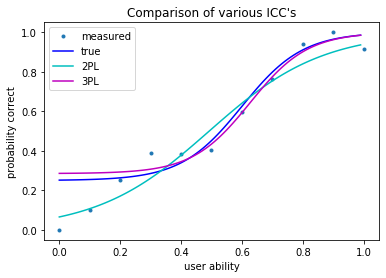

In [8]:
plt.plot(bins, measured_prob_correct, '.', label="measured")
plt.plot(theta, prob_correct, 'b', label="true")
plt.plot(theta, prob_correct_2pl_fit, 'c', label="2PL")
plt.plot(theta, prob_correct_3pl_fit, 'm', label="3PL")
plt.legend()
plt.xlabel("user ability")
plt.ylabel("probability correct")
_ = plt.title("Comparison of various ICC's")

The 3PL fits in particular are quite finnicky, because the function being fit is not very smooth in paramter space (some dimensions are much steeper than others, local minima, etc).

In real-world situations, we recommend running multiple trials with different input parameters to find good convergence (low chi2, no convergence errors).

There are newer methods for performing this type of fit, but we have not had a change to evaluate them yet:
https://journal.r-project.org/archive/2019/RJ-2019-003/RJ-2019-003.pdf